# **Pipeline**

# Читаем базы

In [1]:
import pandas as pd

## База 1

In [ ]:
base_1 = pd.ExcelFile('/content/drive/MyDrive/Системный Блок/пишу тебе/открытки базы/Расшифровка открыток (основная база).xlsx')
base_1 = pd.read_excel(base_1, 'Открытки')
base_1['Номер открытки'] = base_1['Номер открытки'].astype(int)
base_1 = base_1[~(((base_1['Pic_url_1'].isna()) | (base_1['Pic_url_1'] == 0.0)) &
                ((base_1['Pic_url_2'].isna()) | (base_1['Pic_url_2'] == 0.0)))
                ]
base_1.head()

In [10]:
base_1.shape

(6031, 60)

In [11]:
base_1[base_1['Статус (распределено, в процессе, завершено, проблема)'
  ].isin(['Исключено', 0, 'Исключено/ трудный почерк'])].groupby(
      ['Статус (распределено, в процессе, завершено, проблема)', 'Проблема']
      )['Номер открытки'].count()

Статус (распределено, в процессе, завершено, проблема)  Проблема                        
Исключено                                               Большие поля                        30
                                                        Две стороны на одном изображении     6
                                                        Отсутствует                          6
                                                        Требуется поворот                    9
Исключено/ трудный почерк                               Отсутствует                         10
Name: Номер открытки, dtype: int64

In [12]:
base_1[base_1['Статус (распределено, в процессе, завершено, проблема)'
  ].isin(['Исключено', 0, 'Исключено/ трудный почерк'])
  ]['Проблема'].isna().groupby(
    base_1['Статус (распределено, в процессе, завершено, проблема)']
    ).sum().astype(int).reset_index(name='count')

,"Статус (распределено, в процессе, завершено, проблема)",count
0,Исключено,0
1,Исключено/ трудный почерк,0


## База 2

In [ ]:
base_2 = pd.ExcelFile('/content/drive/MyDrive/Системный Блок/пишу тебе/открытки базы/Расшифровка открыток 2 (Ярмарка проектов).xlsx')
base_2 = pd.read_excel(base_2, 'Открытки')
base_2['Номер открытки'] = base_2['Номер открытки'].astype(int)
base_2.head()

In [5]:
base_2.shape

(4968, 60)

## База 3

In [ ]:
base_3 = pd.ExcelFile('/content/drive/MyDrive/Системный Блок/пишу тебе/открытки базы/Расшифровка открыток 3 (Ярмарка проектов).xlsx')
base_3 = pd.read_excel(base_3, 'Открытки')
base_3 = base_3[~base_3['Номер открытки'].isna()]
base_3['Номер открытки'] = base_3['Номер открытки'].astype(int)
base_3.head()

In [7]:
base_3.shape

(10453, 60)

## База 4

In [ ]:
base_4 = pd.ExcelFile('/content/drive/MyDrive/Системный Блок/пишу тебе/открытки базы/_Расшифровка открыток 4 (ярмарка проектов).xlsx')
base_4 = pd.read_excel(base_4, 'Открытки')
base_4 = base_4[~base_4['Номер открытки'].isna()]
base_4['Номер открытки'] = base_4['Номер открытки'].astype(int)
base_4 = base_4[~(((base_4['Pic_url_1'].isna()) | (base_4['Pic_url_1'] == 0.0)) &
                ((base_4['Pic_url_2'].isna()) | (base_4['Pic_url_2'] == 0.0)))
                ]
base_4.head()

In [9]:
base_4.shape

(10827, 60)

## Объединяем базы

In [34]:
base_1['base'] = 1
base_2['base'] = 2
base_3['base'] = 3
base_4['base'] = 4

In [35]:
df = pd.concat([base_1, base_2, base_3, base_4])
df = df[['Номер открытки', 'Pic_url_1', 'Pic_url_2', 'base',
         'Разрешение на публикацию',
         'Статус (распределено, в процессе, завершено, проблема)',
         'Проблема']]
df.shape

(32279, 7)

In [36]:
df['base'].value_counts()

4    10827
3    10453
1     6031
2     4968
Name: base, dtype: int64

## Добавляем информацию с прошлой итерации сжатия

In [ ]:
prev_iter = pd.read_csv(
    '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_postcards-resize-880pix.csv', 
    index_col=0)
prev_iter = prev_iter[['Номер открытки', 'fullsize_filename_1', 'fullsize_filename_2',
                      'resize_filename_1', 'resize_filename_2',
                      'fullsize_readable_1', 'fullsize_readable_2',
                      'resize_url_1', 'resize_url_2',
                      'resize_file_size_1', 'resize_file_size_2']]
prev_iter.head()

In [ ]:
df = df.merge(prev_iter, on='Номер открытки', how='left')
df.head()

In [21]:
df.shape

(32279, 17)

# Помечаем открытки, которые нужно сжать

* еще не сжимали - нет ссылок на сжатые изображения

In [39]:
df['needs_resize'] = df.apply(
    lambda row: True if
    # row['Разрешение на публикацию'] == 'Разрешаю публикацию' and
    # row['Статус (распределено, в процессе, завершено, проблема)'] == 'Проверено' and
    # row['Проблема'] == 'Отсутствует' and
    (pd.isna(row['resize_url_1']) or pd.isna(row['resize_url_2']))
    and row['base'] == 1
    else False,
    axis=1
)

In [40]:
df.groupby('base')['needs_resize'].value_counts()

base  needs_resize
1     True             4348
      False            1683
2     False            4968
3     False           10453
4     False           10827
Name: needs_resize, dtype: int64

# Скачиваем исходники

In [26]:
import requests
import numpy as np
import os
from tqdm import tqdm

In [27]:
# директория для исходников
base_fullsize_dir = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images'
os.makedirs(base_fullsize_dir, exist_ok=True)
os.makedirs(base_fullsize_dir + '/base_1', exist_ok=True)
os.makedirs(base_fullsize_dir + '/base_2', exist_ok=True)
os.makedirs(base_fullsize_dir + '/base_3', exist_ok=True)
os.makedirs(base_fullsize_dir + '/base_4', exist_ok=True)

In [ ]:
# только на первой итерации сжатия
# df['fullsize_filename_1'] = np.nan
# df['fullsize_filename_2'] = np.nan

In [52]:
for ind, row in tqdm(df.iterrows(), total=df.shape[0]):
  if not row['needs_resize']:
    continue

  url_1 = row['Pic_url_1']  # лицевая
  if pd.isna(row['fullsize_filename_1']) and not pd.isna(url_1) and url_1 != 0.0: 
    filename_1 = f"{base_fullsize_dir}/base_{row['base']}/{row['Номер открытки']}-1.jpg"
    pic_1_content = requests.get(url_1).content
    with open (filename_1, 'wb') as pic_1_file:
        pic_1_file.write(pic_1_content)
    df.at[ind, 'fullsize_filename_1'] = filename_1

  url_2 = row['Pic_url_2']  #оборот
  if pd.isna(row['fullsize_filename_2']) and not pd.isna(url_2) and url_2 != 0.0: 
    filename_2 = f"{base_fullsize_dir}/base_{row['base']}/{row['Номер открытки']}-2.jpg"
    pic_2_content = requests.get(url_2).content
    with open (filename_2, 'wb') as pic_2_file:
        pic_2_file.write(pic_2_content)
    df.at[ind, 'fullsize_filename_2'] = filename_2

100%|██████████| 32279/32279 [00:49<00:00, 647.30it/s] 


In [ ]:
df[df['needs_resize']].isna().sum()

In [ ]:
df[df['needs_resize'] & df['fullsize_filename_2'].isna()]

In [36]:
df.to_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_downloaded_fullsize.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_downloaded_fullsize.csv', index_col=0)
df.head()

# Сжимаем изображения

In [45]:
import os
from tqdm import tqdm
import cv2
import imutils

Функция сжатия

In [46]:
resize_max_value = 880
resize_min_value = 600

def do_resize(img):
  # print('orig shape:', img.shape[:2])
  size_ratio = min(img.shape[0], img.shape[1]) / max(img.shape[0], img.shape[1])

  # открытки стандартных размеров 
  if 0.5 < size_ratio < 0.8:
    if img.shape[0] > img.shape[1]:
      img = imutils.resize(img, height=resize_max_value)
    else:
      img = imutils.resize(img, width=resize_max_value)
  
  # нестандартные открытки 
  else: 
    if img.shape[0] > img.shape[1]:
      img = imutils.resize(img, width=resize_min_value)
    else:
      img = imutils.resize(img, height=resize_min_value)
    
  # print('resized shape:', img.shape[:2])
  return img

In [ ]:
# только при первой итерации сжатия
# df['fullsize_readable_1'] = np.nan
# df['fullsize_readable_2'] = np.nan
# df['resize_filename_1'] = np.nan
# df['resize_filename_2'] = np.nan
# df['resize_file_size_1'] = np.nan
# df['resize_file_size_2'] = np.nan

In [47]:
# директория для сжатого
base_resize_dir = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images-resize'
os.makedirs(base_resize_dir + '/base_1', exist_ok=True)
os.makedirs(base_resize_dir + '/base_2', exist_ok=True)
os.makedirs(base_resize_dir + '/base_3', exist_ok=True)
os.makedirs(base_resize_dir + '/base_4', exist_ok=True)

In [55]:
for ind, row in tqdm(df.iterrows(), total=df.shape[0]):
  if not row['needs_resize']:
    continue

  if pd.isna(row['resize_filename_1']):
    try:  # лицевая
      img = cv2.imread(row['fullsize_filename_1'])
      img = do_resize(img)
      output_filename = f"{base_resize_dir}/base_{row['base']}/{row['Номер открытки']}-1-resize.jpg"
      cv2.imwrite(output_filename, img)
      output_file_size = os.path.getsize(output_filename)
      df.at[ind, 'fullsize_readable_1'] = True
      df.at[ind, 'resize_filename_1'] = output_filename
      df.at[ind, 'resize_file_size_1'] = output_file_size
    except:
      # raise
      df.at[ind, 'fullsize_readable_1'] = False

  if pd.isna(row['resize_filename_2']):
    try:  # оборот
      img = cv2.imread(row['fullsize_filename_2'])
      img = do_resize(img)
      output_filename = f"{base_resize_dir}/base_{row['base']}/{row['Номер открытки']}-2-resize.jpg"
      cv2.imwrite(output_filename, img)
      output_file_size = os.path.getsize(output_filename)
      df.at[ind, 'fullsize_readable_2'] = True
      df.at[ind, 'resize_filename_2'] = output_filename
      df.at[ind, 'resize_file_size_2'] = output_file_size
    
    except:
      df.at[ind, 'fullsize_readable_2'] = False

100%|██████████| 32279/32279 [00:12<00:00, 2503.78it/s] 


Проверяем, что размер сжатого файла не превышает допустимый. Должно вывести 0

In [56]:
threshold = 1e6  # 1 Mb
df[
    (df['resize_file_size_1'] > threshold) | 
   (df['resize_file_size_2'] > threshold)
].shape

(0, 18)

# Обработка исключений
Смотрим nan'ы и догружаем вручную при возможности

In [57]:
df[df['needs_resize']].isna().sum()

Номер открытки                                               0
Pic_url_1                                                    0
Pic_url_2                                                    0
base                                                         0
Разрешение на публикацию                                     0
Статус (распределено, в процессе, завершено, проблема)       0
Проблема                                                     0
fullsize_filename_1                                          0
fullsize_filename_2                                          6
resize_filename_1                                            0
resize_filename_2                                            6
fullsize_readable_1                                          0
fullsize_readable_2                                          0
resize_url_1                                              4348
resize_url_2                                              4348
resize_file_size_1                                     

In [59]:
df[(df['needs_resize']) & (df['resize_filename_2'].isna())]

,Номер открытки,Pic_url_1,Pic_url_2,base,Разрешение на публикацию,"Статус (распределено, в процессе, завершено, проблема)",Проблема,fullsize_filename_1,fullsize_filename_2,resize_filename_1,resize_filename_2,fullsize_readable_1,fullsize_readable_2,resize_url_1,resize_url_2,resize_file_size_1,resize_file_size_2,needs_resize
24,94,https://forum.vgd.ru/file.php?fid=59976&key=17...,0,1,Разрешаю публикацию,Помощь модератора/ иностранный язык,Отсутствует,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,True,False,NaN,NaN,NaN,NaN,True
129,433,https://forum.vgd.ru/file.php?fid=189267&key=1...,0,1,Разрешаю публикацию,Помощь модератора/ иностранный язык,Отсутствует,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,True,False,NaN,NaN,NaN,NaN,True
477,966,https://forum.vgd.ru/file.php?fid=192315&key=3...,0,1,Разрешаю публикацию,Исключено,Большие поля,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,True,False,NaN,NaN,NaN,NaN,True
781,1649,https://forum.vgd.ru/file.php?fid=430279&key=1...,0,1,Разрешаю публикацию,Исключено,Большие поля,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,True,False,NaN,NaN,NaN,NaN,True
1018,2197,https://forum.vgd.ru/file.php?fid=59971&key=11...,0,1,Разрешаю публикацию,Исключено,Две стороны на одном изображении,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,True,False,NaN,NaN,NaN,NaN,True
1019,2199,https://forum.vgd.ru/file.php?fid=60371&key=16...,0,1,Разрешаю публикацию,Исключено,Большие поля,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,/content/drive/MyDrive/Системный Блок/пишу те...,NaN,True,False,NaN,NaN,NaN,NaN,True


In [ ]:
!ls '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images/base_4' | grep 225881

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images/base_4/225881-1.jpg')
img.shape

In [ ]:
os.path.getsize('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images-resize/base_4/221178-2-resize.jpg')

In [11]:
df.to_csv('df_resize.csv')

# Загружаем сжатые на s3

## Setup

In [ ]:
!pip install --upgrade urllib3

In [ ]:
!pip install boto3

In [61]:
import boto3
from botocore.config import Config
import os

In [62]:
def get_yandex_service(s3_cred_filename) -> boto3.session.Session.client:
    yandex_session = boto3.session.Session()

    yandex_config = Config(
        region_name='ru-central1',
    )

    s3_credentials = dict()
    with open(s3_cred_filename, 'r') as f:
      for s in f:
        s = s.strip().split(' ')
        s3_credentials[s[0]] = s[1]

    return yandex_session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        aws_access_key_id=s3_credentials['aws_access_key_id'],
        aws_secret_access_key=s3_credentials['aws_secret_access_key'],
        config=yandex_config
    )

In [63]:
client = get_yandex_service('s3_cred_write.txt')

## Создаем бакет
Только один раз, при первой итерации сжатия

In [64]:
bucket_name = 'postcards-resize-880pix'

In [ ]:
# client.create_bucket(Bucket=bucket_name, ACL='public-read')

## Загружаем и сохраняем ссылки

In [ ]:
# только на первой итерации сжатия
# df['resize_url_1'] = np.nan
# df['resize_url_2'] = np.nan

In [65]:
for ind, row in tqdm(df.iterrows(), total=df.shape[0]):
  if not row['needs_resize']:
    continue

  file_path = row['resize_filename_1']  # лицевая
  if not pd.isna(file_path):
    s3_filename = f"{row['Номер открытки']}-1-resize.jpg"
    client.upload_file(file_path, bucket_name, s3_filename)
    resize_url_1 = f'https://storage.yandexcloud.net/{bucket_name}/{s3_filename}'
    df.at[ind, 'resize_url_1'] = resize_url_1

  file_path = row['resize_filename_2']  # оборот
  if not pd.isna(file_path):
    s3_filename = f"{row['Номер открытки']}-2-resize.jpg"
    client.upload_file(file_path, bucket_name, s3_filename)
    resize_url_2 = f'https://storage.yandexcloud.net/{bucket_name}/{s3_filename}'
    df.at[ind, 'resize_url_2'] = resize_url_2

100%|██████████| 32279/32279 [1:37:07<00:00,  5.54it/s]   


In [66]:
df[df['needs_resize']].isna().sum()

Номер открытки                                               0
Pic_url_1                                                    0
Pic_url_2                                                    0
base                                                         0
Разрешение на публикацию                                     0
Статус (распределено, в процессе, завершено, проблема)       0
Проблема                                                     0
fullsize_filename_1                                          0
fullsize_filename_2                                          6
resize_filename_1                                            0
resize_filename_2                                            6
fullsize_readable_1                                          0
fullsize_readable_2                                          0
resize_url_1                                                 0
resize_url_2                                                 6
resize_file_size_1                                     

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(df[(df['needs_resize']) & ((df['resize_url_1'].isna()) | 
                                             (df['resize_url_2'].isna()))])

In [67]:
df.to_csv(
    '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_postcards-resize-880pix.csv'
    )

# Проверка ссылок на валидность
Проверяем 150 случайных открыток, что ссылки на сжатые изображения возвращают читаемые файлы

In [68]:
import requests
import cv2
from tqdm import tqdm

In [69]:
df_sample = df[df['needs_resize']].sample(n=150)

for ind, row in tqdm(df_sample.iterrows(), total=df_sample.shape[0]):
  if pd.isna(row['resize_url_1']):
    continue
  
  pic_content = requests.get(row['resize_url_1']).content
  with open ('pic_1.jpg', 'wb') as pic_file:
      pic_file.write(pic_content)
  try:
    img = cv2.imread('pic_1.jpg')
    img_shape = img.shape
    # print(img_shape)
  except:
    with open('unreadable_images.txt', 'a') as exc_file:
      exc_file.write(f"ID = {row['ID']} pic 1\n")

  pic_content = requests.get(row['resize_url_2']).content
  with open ('pic_2.jpg', 'wb') as pic_file:
      pic_file.write(pic_content)
  try:
    img = cv2.imread('pic_2.jpg')
    img_shape = img.shape
    # print(img_shape)
  except:
    with open('unreadable_images.txt', 'a') as exc_file:
      exc_file.write(f"ID = {row['ID']} pic 2\n")

100%|██████████| 150/150 [05:04<00:00,  2.03s/it]


# Заполняем пропущенные значения

In [71]:
df['resize_url_1'] = df['resize_url_1'].fillna('Исходник недоступен')
df['resize_url_2'] = df['resize_url_2'].fillna('Исходник недоступен')

In [72]:
df.isna().sum()

Номер открытки                                               0
Pic_url_1                                                    0
Pic_url_2                                                    0
base                                                         0
Разрешение на публикацию                                     0
Статус (распределено, в процессе, завершено, проблема)      40
Проблема                                                   515
fullsize_filename_1                                          0
fullsize_filename_2                                          6
resize_filename_1                                          358
resize_filename_2                                          364
fullsize_readable_1                                          0
fullsize_readable_2                                          0
resize_url_1                                                 0
resize_url_2                                                 0
resize_file_size_1                                     

In [73]:
df.to_csv(
    '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_postcards-resize-880pix.csv'
    )

# **Устаревший код**

# База для уже обработанного

In [ ]:
df = df[['Номер открытки', 'Pic_url_1', 'Pic_url_2', 'base',
         'Разрешение на публикацию',
         'Статус (распределено, в процессе, завершено, проблема)',
         'Проблема']]

In [ ]:
df.shape

(22678, 7)

In [ ]:
df['needs_resize'] = df.apply(
    lambda row: True 
    if row['Разрешение на публикацию'] == 'Разрешаю публикацию' and
    row['Статус (распределено, в процессе, завершено, проблема)'] == 'Проверено' and
    row['Проблема'] == 'Отсутствует'
    # and (pd.isna(row['resize_url_1']) or pd.isna(row['resize_url_2']))
    else False,
    axis=1
)

df['needs_resize'].value_counts()

In [ ]:
import os
from tqdm import tqdm

In [ ]:
base_dir_str = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images/'

In [ ]:
base_dir = os.fsencode(base_dir_str)
# dirs_done = ['base_1', 'base_2']
fullsize_filename_1 = dict()
fullsize_filename_2 = dict()

for dr in os.listdir(base_dir):
  sub_dir_str = os.fsdecode(dr)
  # if sub_dir_str in dirs_done:
  #   continue
  sub_dir_str = base_dir_str + sub_dir_str
  print(sub_dir_str)
  sub_dir = os.fsencode(sub_dir_str)

  for f in tqdm(os.listdir(sub_dir)):
    filename = os.fsdecode(f)
    if len(filename.split('-')) == 2:
      # print(filename)
      postcard_id = int(filename.split('-')[0])
      pic = int(filename.split('.')[0].split('-')[1])
      # print('filename =', filename, 'postcard_id =', postcard_id, 'pic =', pic)
    elif len(filename.split('-')) == 3:
      # print(filename)
      postcard_id = int(filename.split('-')[1])
      pic = int(filename.split('.')[0].split('-')[2])
      # print('filename =', filename, 'postcard_id =', postcard_id, 'pic =', pic)
    filename = f'{sub_dir_str}/{filename}'
    # print(filename)
    if pic == 1 and postcard_id not in fullsize_filename_1:
      fullsize_filename_1[postcard_id] = filename
    elif pic == 2 and postcard_id not in fullsize_filename_2:
      fullsize_filename_2[postcard_id] = filename


    # break

  # break

In [ ]:
len(fullsize_filename_1)

22676

In [ ]:
len(fullsize_filename_2)

22461

In [ ]:
base_dir_str = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images-resize/'

In [ ]:
base_dir = os.fsencode(base_dir_str)
# dirs_done = ['base_1', 'base_2']
resize_filename_1 = dict()
resize_filename_2 = dict()

for dr in os.listdir(base_dir):
  sub_dir_str = os.fsdecode(dr)
  # if sub_dir_str in dirs_done:
  #   continue
  sub_dir_str = base_dir_str + sub_dir_str
  print(sub_dir_str)
  sub_dir = os.fsencode(sub_dir_str)

  for f in tqdm(os.listdir(sub_dir)):
    filename = os.fsdecode(f)
    # print(filename)
    if len(filename.split('-')) == 3:
      # print(filename)
      postcard_id = int(filename.split('-')[0])
      pic = int(filename.split('.')[0].split('-')[1])
      # print('filename =', filename, 'postcard_id =', postcard_id, 'pic =', pic)
    elif len(filename.split('-')) == 4:
      # print(filename)
      postcard_id = int(filename.split('-')[1])
      pic = int(filename.split('.')[0].split('-')[2])
      # print('filename =', filename, 'postcard_id =', postcard_id, 'pic =', pic)
    filename = f'{sub_dir_str}/{filename}'
    # print(filename)
    if pic == 1 and postcard_id not in resize_filename_1:
      resize_filename_1[postcard_id] = filename
    elif pic == 2 and postcard_id not in resize_filename_2:
      resize_filename_2[postcard_id] = filename


    # break

  # break

In [ ]:
len(resize_filename_1)

22649

In [ ]:
len(resize_filename_2)

22433

In [ ]:
fullsize_filename_1 = pd.DataFrame.from_dict(fullsize_filename_1, orient='index').reset_index().rename(
    columns={'index': 'Номер открытки', 0: 'fullsize_filename_1'}
)
fullsize_filename_2 = pd.DataFrame.from_dict(fullsize_filename_2, orient='index').reset_index().rename(
    columns={'index': 'Номер открытки', 0: 'fullsize_filename_2'}
)

In [ ]:
resize_filename_1 = pd.DataFrame.from_dict(resize_filename_1, orient='index').reset_index().rename(
    columns={'index': 'Номер открытки', 0: 'resize_filename_1'}
)
resize_filename_2 = pd.DataFrame.from_dict(resize_filename_2, orient='index').reset_index().rename(
    columns={'index': 'Номер открытки', 0: 'resize_filename_2'}
)

In [ ]:
filename_df = fullsize_filename_1.merge(fullsize_filename_2, on='Номер открытки', how='outer').merge(
    resize_filename_1, on='Номер открытки', how='outer'
).merge(resize_filename_2, on='Номер открытки', how='outer')
filename_df.shape

(22677, 5)

In [ ]:
filename_df.head()

In [ ]:
df = df.merge(filename_df, on='Номер открытки', how='outer')
df.head()

In [ ]:
df.shape

(22678, 16)

In [ ]:
df[(df['needs_resize'] == True) & (~df['fullsize_filename_1'].isna()) & 
   (~df['fullsize_filename_2'].isna())].shape

(11596, 12)

In [ ]:
df.isna().sum()

In [ ]:
df['fullsize_readable_1'] = df['resize_filename_1'].apply(
    lambda x: False if pd.isna(x) else True
)
df['fullsize_readable_2'] = df['resize_filename_2'].apply(
    lambda x: False if pd.isna(x) else True
)

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(df[df['Номер открытки'] == 1037])

In [ ]:
import numpy as np

In [ ]:
df.at[5314, 'fullsize_filename_1'] = np.nan
# df.at[5314, 'fullsize_readable_1'] = False

In [ ]:
import cv2

In [ ]:
df['resize_url_1'] = df.apply(
    lambda row: f"https://storage.yandexcloud.net/{bucket_name}/{row['Номер открытки']}-1-resize.jpg"
    if row['needs_resize'] and 
    not pd.isna(row['resize_filename_1']) and not pd.isna(row['resize_filename_2'])
    else np.nan,
    axis=1
    )

df['resize_url_2'] = df.apply(
    lambda row: f"https://storage.yandexcloud.net/{bucket_name}/{row['Номер открытки']}-2-resize.jpg"
    if row['needs_resize'] and 
    not pd.isna(row['resize_filename_1']) and not pd.isna(row['resize_filename_2'])
    else np.nan,
    axis=1
    )

In [ ]:
df[(df['needs_resize']) & (~df['resize_url_1'].isna()) & (~df['resize_url_2'].isna())].shape

(11595, 16)

In [ ]:
df.shape

(22678, 16)

In [ ]:
df.to_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_postcards-resize-880pix.csv')

In [ ]:
nan_ids = []
with open('problematic_ids.txt', 'r') as f:
  for s in f:
    num = int(s.strip())
    nan_ids.append(num)
len(nan_ids)

49

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/df_postcards-resize-880pix.csv', index_col=0)
df.head()

In [ ]:
import requests
import cv2

In [ ]:
for ind, row in df.iterrows():
  if row['Номер открытки'] not in nan_ids or not row['needs_resize']:
    continue

  print('ID =', row['Номер открытки'])
  if pd.isna(row['resize_url_1']):
    print('resize_url_1 = NaN')
  else:
    pic_content = requests.get(row['resize_url_1']).content
    with open ('pic_1.jpg', 'wb') as pic_file:
        pic_file.write(pic_content)
    try:
      img = cv2.imread('pic_1.jpg')
      img_shape = img.shape
      print('resize_url_1: valid')
    except:
      print('resize_url_1: invalid')

  if pd.isna(row['resize_url_2']):
    print('resize_url_2 = NaN')
  else:
    pic_content = requests.get(row['resize_url_2']).content
    with open ('pic_2.jpg', 'wb') as pic_file:
        pic_file.write(pic_content)
    try:
      img = cv2.imread('pic_2.jpg')
      img_shape = img.shape
      print('resize_url_2: valid')
    except:
      print('resize_url_2: invalid')

  print()

In [ ]:
from tqdm import tqdm

In [ ]:
for ind, row in tqdm(df.iterrows(), total=df.shape[0]):
  if row['Номер открытки'] not in nan_ids or not row['needs_resize']:
    continue

  file_path = row['resize_filename_1']  # лицевая
  if not pd.isna(file_path):
    s3_filename = f"{row['Номер открытки']}-1-resize.jpg"
    # print(file_path)
    # print(s3_filename)
    client.upload_file(file_path, bucket_name, s3_filename)
    resized_url_1 = f'https://storage.yandexcloud.net/{bucket_name}/{s3_filename}'
    df.at[ind, 'resized_url_1'] = resized_url_1

  file_path = row['resize_filename_2']  # оборот
  if not pd.isna(file_path):
    s3_filename = f"{row['Номер открытки']}-2-resize.jpg"
    # print(file_path)
    # print(s3_filename)
    client.upload_file(file_path, bucket_name, s3_filename)
    resized_url_2 = f'https://storage.yandexcloud.net/{bucket_name}/{s3_filename}'
    df.at[ind, 'resized_url_2'] = resized_url_2

100%|██████████| 22678/22678 [00:25<00:00, 881.73it/s]


# Скачивание API s3

## Setup

In [ ]:
!pip install --upgrade urllib3

In [ ]:
!pip install boto3

In [ ]:
import boto3
from botocore.config import Config
import os

In [ ]:
def get_yandex_service() -> boto3.session.Session.client:
    yandex_session = boto3.session.Session()

    yandex_config = Config(
        region_name='ru-central1',
    )

    return yandex_session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        # aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'), 
        aws_access_key_id='YCAJE2yFulzqL6FBegC-HPkKZ',
        # aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY'), 
        aws_secret_access_key='YCOy6fszsTIViwPd7SC6fo4Ol0mhWXatb5Q2Lvv-',
        config=yandex_config
    )

In [ ]:
client = get_yandex_service()

## Список бакетов

In [ ]:
bucket_list = client.list_buckets()['Buckets']
bucket_list

## Скачиваем базы

In [ ]:
import re

In [ ]:
base_dir = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images'

In [ ]:
def download(row):
  try:
    s = row['Pic_url_1'].split('/')
    bucket_name = re.search('https://storage.yandexcloud.net/(.+?)/', url).group(1)
    bucket_name = s[3]
    # print('bucket_name =', bucket_name)
    filename = '/'.join(s[4:]).replace('%20', ' ')
    # print('filename =', filename)
    filename_gdisk = f"{base_dir}/{bucket_name}/{row['base']}-{row['Номер открытки']}-1.jpg"
    with open(filename_gdisk, 'wb') as f:
      client.download_fileobj(bucket_name, filename, f)
  except:
    raise
    # with open('exceptions.txt', 'a') as exc_file:
      # exc_file.write(f"ID = {row['Номер открытки']}\n")

  try:
    s = row['Pic_url_2'].split('/')
    bucket_name = re.search('https://storage.yandexcloud.net/(.+?)/', url).group(1)
    bucket_name = s[3]
    # print('bucket_name =', bucket_name)
    filename = '/'.join(s[4:]).replace('%20', ' ')
    # print('filename =', filename)
    filename_gdisk = f"{base_dir}/{bucket_name}/{row['base']}-{row['Номер открытки']}-2.jpg"
    with open(filename_gdisk, 'wb') as f:
      client.download_fileobj(bucket_name, filename, f)
  except:
    raise
    # with open('exceptions.txt', 'a') as exc_file:
      # exc_file.write(f"ID = {row['Номер открытки']}\n")

In [ ]:
for b in bucket_list:
  os.mkdir(f"{base_dir}/{b['Name']}")

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
df.progress_apply(download, axis=1)

# Сжатие при помощи Imagemagick

In [ ]:
def do_resize(filename_in, filename_out):
  img = cv2.imread(filename_in)
  print('before:', img.shape[:2])
  subprocess.run(f'resize.sh {filename_in} {filename_out}', 
                      stdout=open(filename_out, "w"), 
                      shell=True)
  img = cv2.imread(filename_out)
  print('after:', img.shape[:2])
  print()

In [ ]:
import subprocess

In [ ]:
filename_out = '3_resize.jpg'
filename_in = '1_1.jpg'

with open(filename_out, 'w') as fout:
  subprocess.run(['resize.sh', filename_in, filename_out], 
                  stdout=subprocess.PIPE,
                  stderr=subprocess.PIPE,
                  universal_newlines=True,
                  shell=True)

In [ ]:
# os.system(f'resize.sh {filename_in} {filename_out}')
stream = os.popen(f'resize.sh {filename_in} {filename_out}')
output = stream.read()
output

''

In [ ]:
do_resize('1_1.jpg', '3_resize.jpg')

# Ревизия

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np
import json
import pandas as pd

## До сжатия

In [ ]:
base_dir_str = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images/'

In [ ]:
base_dir = os.fsencode(base_dir_str)
dirs_done = ['base_1', 'base_2']
revision_data = dict()
    
for dr in os.listdir(base_dir):
  sub_dir_str = os.fsdecode(dr)
  if sub_dir_str in dirs_done:
    continue
  sub_dir_str = base_dir_str + sub_dir_str
  print(sub_dir_str)
  sub_dir = os.fsencode(sub_dir_str)

  count = 0
  for f in tqdm(os.listdir(sub_dir)):
    count += 1
    # if count < 980:
    #   continue
    input_filename = os.fsdecode(f)
    postcard_id = int(input_filename.split('-')[1])
    pic = int(input_filename.split('.')[0].split('-')[2])
    # print('postcard_id =', postcard_id, 'pic =', pic)
    input_filename = f'{sub_dir_str}/{input_filename}'

    if postcard_id not in revision_data:
      revision_data[postcard_id] = {1: None, 2: None}

    try:
      img = cv2.imread(input_filename)
      revision_data[postcard_id][pic] = {
          'orig_filename': input_filename,
          'orig_readable': True,
          'orig_height': img.shape[0],
          'orig_width': img.shape[1],
          'orig_filesize': os.path.getsize(input_filename)
      }
    except:
      # raise
      revision_data[postcard_id][pic] = {
          'orig_filename': input_filename,
          'orig_readable': False,
          'orig_height': np.nan,
          'orig_width': np.nan,
          'orig_filesize': os.path.getsize(input_filename)
      }
    # break
  
  # break

In [ ]:
with open('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_orig_base_3.json', 'w') as fp:
    json.dump(revision_data, fp)

In [ ]:
def get_revision_df(file_path):
  with open(file_path, 'r') as json_file:
    revision_data = json.loads(json_file.read())
  
  revision_new = dict()
  for postcard_id in revision_data:

    if revision_data[postcard_id]['1'] is None and revision_data[postcard_id]['2'] is None:
      revision_new[postcard_id] = {
        'orig_filename_1': '',
          'orig_readable_1': '',
          'orig_height_1': '',
          'orig_width_1': '',
          'orig_filesize_1': '',

          'orig_filename_2': '',
          'orig_readable_2': '',
          'orig_height_2': '',
          'orig_width_2': '',
          'orig_filesize_2': '',
    }
    elif revision_data[postcard_id]['1'] is None:
      revision_new[postcard_id] = {
        'orig_filename_1': '',
        'orig_readable_1': '',
        'orig_height_1': '',
        'orig_width_1': '',
        'orig_filesize_1': '',

        'orig_filename_2': revision_data[postcard_id]['2']['orig_filename'],
        'orig_readable_2': revision_data[postcard_id]['2']['orig_readable'],
        'orig_height_2': revision_data[postcard_id]['2']['orig_height'],
        'orig_width_2': revision_data[postcard_id]['2']['orig_width'],
        'orig_filesize_2': revision_data[postcard_id]['2']['orig_filesize'],
    }
    elif revision_data[postcard_id]['2'] is None:
      revision_new[postcard_id] = {
        'orig_filename_1': revision_data[postcard_id]['1']['orig_filename'],
        'orig_readable_1': revision_data[postcard_id]['1']['orig_readable'],
        'orig_height_1': revision_data[postcard_id]['1']['orig_height'],
        'orig_width_1': revision_data[postcard_id]['1']['orig_width'],
        'orig_filesize_1': revision_data[postcard_id]['1']['orig_filesize'],

        'orig_filename_2': '',
        'orig_readable_2': '',
        'orig_height_2': '',
        'orig_width_2': '',
        'orig_filesize_2': '',
    }
    else:
      revision_new[postcard_id] = {
        'orig_filename_1': revision_data[postcard_id]['1']['orig_filename'],
        'orig_readable_1': revision_data[postcard_id]['1']['orig_readable'],
        'orig_height_1': revision_data[postcard_id]['1']['orig_height'],
        'orig_width_1': revision_data[postcard_id]['1']['orig_width'],
        'orig_filesize_1': revision_data[postcard_id]['1']['orig_filesize'],

        'orig_filename_2': revision_data[postcard_id]['2']['orig_filename'],
        'orig_readable_2': revision_data[postcard_id]['2']['orig_readable'],
        'orig_height_2': revision_data[postcard_id]['2']['orig_height'],
        'orig_width_2': revision_data[postcard_id]['2']['orig_width'],
        'orig_filesize_2': revision_data[postcard_id]['2']['orig_filesize'],
      }

  df = pd.DataFrame.from_dict(revision_new, orient='index')
  df = df.reset_index().rename(columns={'index': 'ID'})
  return df

In [ ]:
revision_orig_df = pd.concat([
    get_revision_df('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_orig_base_1.json'),
    get_revision_df('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_orig_base_2.json'),
    get_revision_df('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_orig_base_3.json'),
])

In [ ]:
revision_orig_df = revision_orig_df.replace('', np.nan)

In [ ]:
revision_orig_df['ID'] = revision_orig_df['ID'].astype(int)
revision_orig_df['orig_height_1'] = revision_orig_df['orig_height_1'].astype(float)
revision_orig_df['orig_width_1'] = revision_orig_df['orig_width_1'].astype(float)
revision_orig_df['orig_filesize_1'] = revision_orig_df['orig_filesize_1'].astype(float)
revision_orig_df['orig_readable_1'] = revision_orig_df['orig_readable_1'].astype(bool)
revision_orig_df['orig_height_2'] = revision_orig_df['orig_height_2'].astype(float)
revision_orig_df['orig_width_2'] = revision_orig_df['orig_width_2'].astype(float)
revision_orig_df['orig_filesize_2'] = revision_orig_df['orig_filesize_2'].astype(float)
revision_orig_df['orig_readable_2'] = revision_orig_df['orig_readable_2'].astype(bool)

In [ ]:
revision_orig_df.dtypes

In [ ]:
revision_orig_df = revision_orig_df.sort_values(by='ID').reset_index(drop=True)

In [ ]:
revision_orig_df.head()

In [ ]:
revision_orig_df.shape

(27645, 11)

In [ ]:
revision_orig_df['ID'].nunique()

22677

In [ ]:
revision_orig_df['ID'].max()

215419

In [ ]:
revision_orig_df.isna().sum()

In [ ]:
revision_orig_df.to_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_orig_df.csv')

## После сжатия

In [ ]:
base_dir_str = '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/images-resize/'

In [ ]:
base_dir = os.fsencode(base_dir_str)
dirs_done = ['base_1', 'base_2']
revision_data = dict()
    
for dr in os.listdir(base_dir):
  sub_dir_str = os.fsdecode(dr)
  if sub_dir_str in dirs_done:
    continue
  sub_dir_str = base_dir_str + sub_dir_str
  print(sub_dir_str)
  sub_dir = os.fsencode(sub_dir_str)

  count = 0
  for f in tqdm(os.listdir(sub_dir)):
    count += 1
    # if count < 980:
    #   continue
    input_filename = os.fsdecode(f)
    postcard_id = int(input_filename.split('-')[1])
    pic = int(input_filename.split('.')[0].split('-')[2])
    # print('postcard_id =', postcard_id, 'pic =', pic)
    input_filename = f'{sub_dir_str}/{input_filename}'

    if postcard_id not in revision_data:
      revision_data[postcard_id] = {1: None, 2: None}

    try:
      img = cv2.imread(input_filename)
      revision_data[postcard_id][pic] = {
          'resize_filename': input_filename,
          'resize_readable': True,
          'resize_height': img.shape[0],
          'resize_width': img.shape[1],
          'resize_filesize': os.path.getsize(input_filename)
      }
    except:
      # raise
      revision_data[postcard_id][pic] = {
          'resize_filename': input_filename,
          'resize_readable': False,
          'resize_height': np.nan,
          'resize_width': np.nan,
          'resize_filesize': os.path.getsize(input_filename)
      }
    # break
  
  # break

In [ ]:
with open('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_resize_base_3.json', 'w') as fp:
    json.dump(revision_data, fp)

In [ ]:
def get_revision_df(file_path):
  with open(file_path, 'r') as json_file:
    revision_data = json.loads(json_file.read())
  
  revision_new = dict()
  for postcard_id in revision_data:

    if revision_data[postcard_id]['1'] is None and revision_data[postcard_id]['2'] is None:
      revision_new[postcard_id] = {
        'resize_filename_1': '',
          'resize_readable_1': '',
          'resize_height_1': '',
          'resize_width_1': '',
          'resize_filesize_1': '',

          'resize_filename_2': '',
          'resize_readable_2': '',
          'resize_height_2': '',
          'resize_width_2': '',
          'resize_filesize_2': '',
    }
    elif revision_data[postcard_id]['1'] is None:
      revision_new[postcard_id] = {
        'resize_filename_1': '',
          'resize_readable_1': '',
          'resize_height_1': '',
          'resize_width_1': '',
          'resize_filesize_1': '',

          'resize_filename_2': revision_data[postcard_id]['2']['resize_filename'],
          'resize_readable_2': revision_data[postcard_id]['2']['resize_readable'],
          'resize_height_2': revision_data[postcard_id]['2']['resize_height'],
          'resize_width_2': revision_data[postcard_id]['2']['resize_width'],
          'resize_filesize_2': revision_data[postcard_id]['2']['resize_filesize'],
    }
    elif revision_data[postcard_id]['2'] is None:
      revision_new[postcard_id] = {
        'resize_filename_1': revision_data[postcard_id]['1']['resize_filename'],
        'resize_readable_1': revision_data[postcard_id]['1']['resize_readable'],
        'resize_height_1': revision_data[postcard_id]['1']['resize_height'],
        'resize_width_1': revision_data[postcard_id]['1']['resize_width'],
        'resize_filesize_1': revision_data[postcard_id]['1']['resize_filesize'],

        'resize_filename_2': '',
          'resize_readable_2': '',
          'resize_height_2': '',
          'resize_width_2': '',
          'resize_filesize_2': '',
    }
    else:
      revision_new[postcard_id] = {
          'resize_filename_1': revision_data[postcard_id]['1']['resize_filename'],
        'resize_readable_1': revision_data[postcard_id]['1']['resize_readable'],
        'resize_height_1': revision_data[postcard_id]['1']['resize_height'],
        'resize_width_1': revision_data[postcard_id]['1']['resize_width'],
        'resize_filesize_1': revision_data[postcard_id]['1']['resize_filesize'],

          'resize_filename_2': revision_data[postcard_id]['2']['resize_filename'],
          'resize_readable_2': revision_data[postcard_id]['2']['resize_readable'],
          'resize_height_2': revision_data[postcard_id]['2']['resize_height'],
          'resize_width_2': revision_data[postcard_id]['2']['resize_width'],
          'resize_filesize_2': revision_data[postcard_id]['2']['resize_filesize'],
      }

  df = pd.DataFrame.from_dict(revision_new, orient='index')
  df = df.reset_index().rename(columns={'index': 'ID'})
  return df

In [ ]:
revision_resize_df = pd.concat([
    get_revision_df('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_resize_base_1.json'),
    get_revision_df('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_resize_base_2.json'),
    get_revision_df('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_resize_base_3.json'),
])

In [ ]:
revision_resize_df = revision_resize_df.replace('', np.nan)

In [ ]:
revision_resize_df['ID'] = revision_resize_df['ID'].astype(int)
revision_resize_df['resize_height_1'] = revision_resize_df['resize_height_1'].astype(float)
revision_resize_df['resize_width_1'] = revision_resize_df['resize_width_1'].astype(float)
revision_resize_df['resize_filesize_1'] = revision_resize_df['resize_filesize_1'].astype(float)
revision_resize_df['resize_readable_1'] = revision_resize_df['resize_readable_1'].astype(bool)
revision_resize_df['resize_height_2'] = revision_resize_df['resize_height_2'].astype(float)
revision_resize_df['resize_width_2'] = revision_resize_df['resize_width_2'].astype(float)
revision_resize_df['resize_filesize_2'] = revision_resize_df['resize_filesize_2'].astype(float)
revision_resize_df['resize_readable_2'] = revision_resize_df['resize_readable_2'].astype(bool)

In [ ]:
revision_resize_df.dtypes

In [ ]:
revision_resize_df = revision_resize_df.sort_values(by='ID').reset_index(drop=True)

In [ ]:
revision_resize_df.head()

In [ ]:
revision_resize_df.shape

(27547, 11)

In [ ]:
revision_resize_df['ID'].nunique()

22647

In [ ]:
revision_resize_df['ID'].max()

215419

In [ ]:
revision_resize_df.isna().sum()

In [ ]:
revision_resize_df.to_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_resize_df.csv')

## Объединяем данные

In [ ]:
revision_df = pd.read_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision/revision_orig_df.csv', index_col=0)
revision_df.head()

In [ ]:
revision_df = revision_df.merge(
    pd.read_csv(
        '/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision/revision_resize_df.csv', 
        index_col=0), 
    on='ID', how='outer')
revision_df.head()

In [ ]:
revision_df.shape

(37445, 21)

In [ ]:
revision_df.to_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision_df_merged.csv')

In [ ]:
import pandas as pd

In [ ]:
revision_df = pd.read_csv('/content/drive/MyDrive/Системный Блок/пишу тебе/сжатие изображений/revision/revision_df_merged.csv', index_col=0)
revision_df.head()

In [ ]:
revision_df = revision_df.drop_duplicates(subset='ID')
revision_df.shape

(22677, 21)

Merge с основной таблицей (базой открыток)

In [ ]:
df = df[['Номер открытки', 'Pic_url_1', 'Pic_url_2', 'base', 
         'Разрешение на публикацию', 
         'Статус (распределено, в процессе, завершено, проблема)', 
         'Проблема']]
df = df.rename(columns={'Номер открытки': 'ID'})
df.head()

In [ ]:
df.shape

(22677, 7)

In [ ]:
revision_df = df.merge(revision_df, on='ID', how='outer')
revision_df.head()

In [ ]:
revision_df.shape

(22678, 27)

# Анализ ревизии

## Размер сжатого файла

Переводим в Мб

In [ ]:
revision_df['resize_filesize_1'] = revision_df['resize_filesize_1'] / 1e6
revision_df['resize_filesize_2'] = revision_df['resize_filesize_2'] / 1e6

Строим график распределения

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

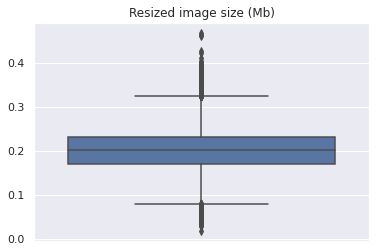

In [ ]:
resize_filesizes = revision_df['resize_filesize_1'].to_list() + \
  revision_df['resize_filesize_2'].to_list()
sns.boxplot(y=resize_filesizes);
plt.title('Resized image size (Mb)');

Ограничению в 1 Мб удовлетворяет

## Открытки нестандартных размеров

Считаем отношение длин сторон исходника (меньшая сторона к большей)

In [ ]:
revision_df['orig_ratio_1'] = revision_df.apply(
    lambda row: min(row['orig_height_1'], row['orig_width_1']) / max(
        row['orig_height_1'], row['orig_width_1']),
    axis=1
)
revision_df['orig_ratio_2'] = revision_df.apply(
    lambda row: min(row['orig_height_2'], row['orig_width_2']) / max(
        row['orig_height_2'], row['orig_width_2']),
    axis=1
)

Строим график

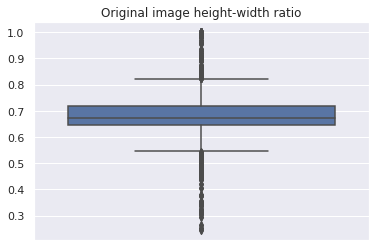

In [ ]:
orig_pix_ratios = revision_df['orig_ratio_1'].to_list() + revision_df['orig_ratio_1'].to_list()
sns.boxplot(y=orig_pix_ratios);
plt.title('Original image height-width ratio');

Если отношение сторон **не** на отрезке [0.5; 0.8], то сжимаем так, чтобы меньшая сторона была 600 пикселей. Иначе применяем общий метод сжатия - бОльшая сторона до 880 пикселей из расчета получить 150 dpi.

In [ ]:
revision_df[(revision_df['orig_ratio_1'] < 0.5) | (revision_df['orig_ratio_1'] > 0.8)].shape

(451, 23)

In [ ]:
revision_df[(revision_df['orig_ratio_2'] < 0.5) | (revision_df['orig_ratio_2'] > 0.8)].shape

(159, 23)

Заново сжимаем открытки нестандартного размера

In [ ]:
resize_max_value = 880
resize_min_value = 600

def do_resize(input_filename, output_filename):
  # if 0.5 < size_ratio < 0.8:
    # img = cv2.imread(input_filename)
    # if img.shape[0] > img.shape[1]:
    #   img = imutils.resize(img, height=resize_value)
    # else:
    #   img = imutils.resize(img, width=resize_value)
    # cv2.imwrite(output_filename, img)
  
  img = cv2.imread(input_filename)
  # print('orig shape:', img.shape[:2])
  if img.shape[0] > img.shape[1]:
    img = imutils.resize(img, width=resize_min_value)
  else:
    img = imutils.resize(img, height=resize_min_value)
  cv2.imwrite(output_filename, img)
  # print('resized shape:', img.shape[:2])
  
  output_file_size = os.path.getsize(output_filename) / 1e6
  if output_file_size >= 1:
    print('Resized image is too big:', input_filename)

In [ ]:
for ind, row in tqdm(revision_df.iterrows(), total=revision_df.shape[0]):
  if row['orig_ratio_1'] < 0.5 or row['orig_ratio_1'] > 0.8:
    do_resize(row['orig_filename_1'], row['resize_filename_1'])
  if row['orig_ratio_2'] < 0.5 or row['orig_ratio_2'] > 0.8:
    do_resize(row['orig_filename_2'], row['resize_filename_2'])
  # break

100%|██████████| 22677/22677 [02:44<00:00, 137.71it/s]


## Пропущенные значения

In [ ]:
revision_df.isna().sum()

In [ ]:
revision_df[revision_df.isna().any(axis=1)].to_csv('revision_df_rows_with_nan.csv')

In [ ]:
revision_df[revision_df['orig_filename_1'].isna()]

In [ ]:
revision_df[revision_df['orig_height_1'].isna()]